<span style="color: rgb(112, 112, 112);">**in the name of God**</sapn>

---

- **<span style="color: #808080;">Parsa Bukani - 810102501</span>**
- **<span style="color: #808080;">Mani Hosseini - 810102552</span>**
- **<span style="color: #808080;">Erfan Falahati - 810102491</span>**

# <span style="color: rgb(112, 112, 112);">**Task 3: LLM for MCQs**</sapn>

In [3]:
import math
import torch
import os
import evaluate
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
from transformers import (
    DataCollatorForMultipleChoice,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer,
    AutoModelForMultipleChoice,
    AutoTokenizer,
    EarlyStoppingCallback,
)
import matplotlib.pyplot as plt
from datasets import load_dataset
from huggingface_hub import login
from peft import LoraConfig, get_peft_model, PeftModel
from sklearn.metrics import confusion_matrix, accuracy_score


plt.style.use("seaborn-v0_8")

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_MODEL_ID = "google-bert/bert-base-uncased"
GENERATIVE_MODEL_ID = "google/flan-t5-large"
FINAL_ADAPTER_PATH = "./final-swag-adapter"

print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
using_colab = False
GOOGLE_DRIVE_PATH = "/content/drive/My Drive/Task#3"

if using_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir(GOOGLE_DRIVE_PATH)

# <span style="color: rgb(85, 186, 226);">**Hugging face access token**</sapn>

In [ ]:
login(token="Enter")

# <span style="color: rgb(85, 186, 226);">**Loading the dataset**</sapn>

In [148]:
swag_dataset = load_dataset('swag')

# <span style="color: rgb(85, 186, 226);">**Analyse the dataset**</sapn>

In [ ]:
train_df = swag_dataset.get('train').to_pandas()
valid_df = swag_dataset.get('validation').to_pandas()
test_df = swag_dataset.get('test').to_pandas()
df = pd.concat([train_df, valid_df, test_df])

In [ ]:
print(f"train set size: {len(train_df)/1000}k")
print(f"validation set size: {len(valid_df)/1000}k")
print(f"test set size: {len(test_df)/1000}k")

train set size: 73.546k
validation set size: 20.006k
test set size: 20.005k


In [ ]:
df.head()

,video-id,fold-ind,startphrase,sent1,sent2,gold-source,ending0,ending1,ending2,ending3,label
0,anetv_jkn6uvmqwh4,3416,Members of the procession walk down the street...,Members of the procession walk down the street...,A drum line,gold,passes by walking down the street playing thei...,has heard approaching them.,arrives and they're outside dancing and asleep.,turns the lead singer watches the performance.,0
1,anetv_jkn6uvmqwh4,3417,A drum line passes by walking down the street ...,A drum line passes by walking down the street ...,Members of the procession,gen,are playing ping pong and celebrating one left...,wait slowly towards the cadets.,continues to play as well along the crowd alon...,"continue to play marching, interspersed.",3
2,anetv_jkn6uvmqwh4,3415,A group of members in green uniforms walks wav...,A group of members in green uniforms walks wav...,Members of the procession,gold,pay the other coaches to cheer as people this ...,walk down the street holding small horn brass ...,is seen in the background.,are talking a couple of people playing a game ...,1
3,anetv_jkn6uvmqwh4,3417,A drum line passes by walking down the street ...,A drum line passes by walking down the street ...,Members of the procession,gen,are playing ping pong and celebrating one left...,wait slowly towards the cadets.,makes a square call and ends by jumping down i...,play and go back and forth hitting the drums w...,3
4,anetv_Bri_myFFu4A,2408,The person plays a song on the violin. The man,The person plays a song on the violin.,The man,gold,finishes the song and lowers the instrument.,hits the saxophone and demonstrates how to pro...,finishes massage the instrument again and cont...,continues dancing while the man gore the music...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113557 entries, 0 to 20004
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   video-id     113557 non-null  object
 1   fold-ind     113557 non-null  object
 2   startphrase  113557 non-null  object
 3   sent1        113557 non-null  object
 4   sent2        113557 non-null  object
 5   gold-source  113557 non-null  object
 6   ending0      113557 non-null  object
 7   ending1      113557 non-null  object
 8   ending2      113557 non-null  object
 9   ending3      113557 non-null  object
 10  label        113557 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 10.4+ MB


In [ ]:
df.isnull().sum()

,0
video-id,0
fold-ind,0
startphrase,0
sent1,0
sent2,0
gold-source,0
ending0,0
ending1,0
ending2,0
ending3,0


In [ ]:
df.duplicated().sum()

np.int64(0)

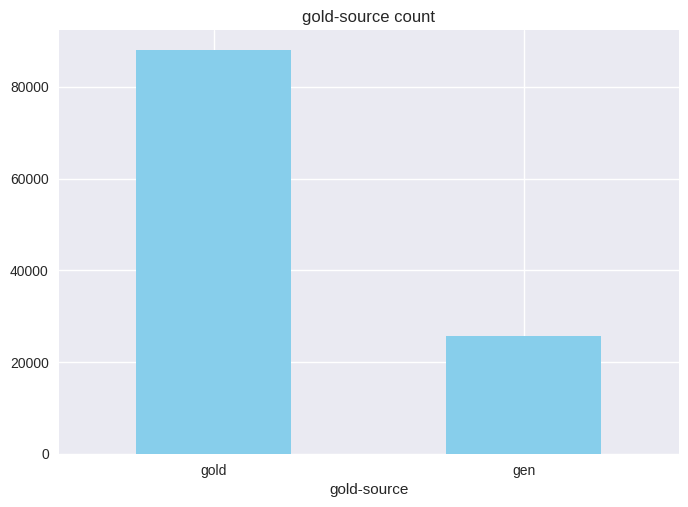

In [ ]:
source_count = df['gold-source'].value_counts()

source_count.plot(kind='bar', title='gold-source count', color='skyblue')
plt.xticks(rotation=0)
plt.show()

In [ ]:
df_v2 = df.copy()
df_v2['len_sent1'] = df_v2['sent1'].apply(lambda x: len(x.split()))
df_v2['len_sent2'] = df_v2['sent2'].apply(lambda x: len(x.split()))
df_v2['len_end0'] = df_v2['ending0'].apply(lambda x: len(x.split()))
df_v2['len_end1'] = df_v2['ending1'].apply(lambda x: len(x.split()))
df_v2['len_end2'] = df_v2['ending2'].apply(lambda x: len(x.split()))
df_v2['len_end3'] = df_v2['ending3'].apply(lambda x: len(x.split()))

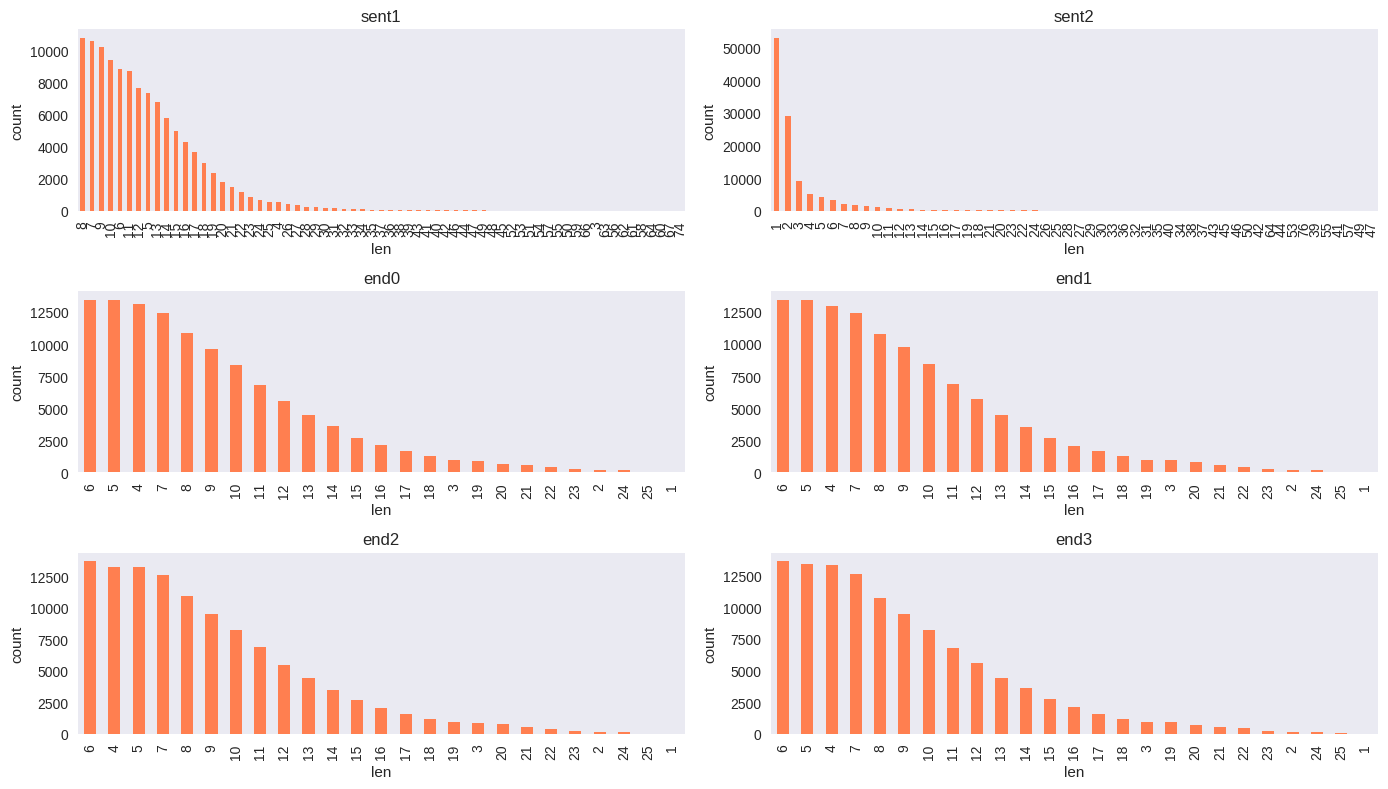

In [ ]:
len_columns = ['len_sent1', 'len_sent2', 'len_end0', 'len_end1', 'len_end2', 'len_end3']

plt.figure(figsize=(14, 8))

for i, col in enumerate(len_columns, 1):
    plt.subplot(3, 2, i)
    ax = df_v2[col].value_counts().plot(kind='bar', color='coral', grid=False)
    plt.title(col.split('_')[1])
    plt.xlabel('len')
    plt.ylabel('count')

plt.tight_layout()
plt.show()

In [ ]:
df_v2[len_columns].describe()

,len_sent1,len_sent2,len_end0,len_end1,len_end2,len_end3
count,113557.000000,113557.000000,113557.000000,113557.000000,113557.000000,113557.000000
mean,11.538082,2.700617,8.667119,8.690068,8.660320,8.651461
std,5.382825,3.147949,4.009486,4.021567,4.018033,4.018416
min,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8.000000,1.000000,6.000000,6.000000,6.000000,6.000000
50%,10.000000,2.000000,8.000000,8.000000,8.000000,8.000000
75%,14.000000,3.000000,11.000000,11.000000,11.000000,11.000000
max,74.000000,76.000000,25.000000,25.000000,25.000000,25.000000


# <span style="color:rgb(85, 186, 226);">**Preprocess the dataset**</sapn>

In [149]:
def preprocess(batch: dict, tokenizer):
    batch_size = len(batch['sent1'])
    all_candidates = []
    for i in range(batch_size):
        full_sentence = batch['sent1'][i] + ' ' + batch['sent2'][i]
        for k in range(4):
            candidate = full_sentence + ' ' + batch[f"ending{k}"][i]
            all_candidates.append(candidate)

    tokenized = tokenizer(all_candidates, return_tensors=None, truncation=True, max_length=256)

    def unflatten(lst):
        return [lst[i*4: (i+1)*4] for i in range(batch_size)]

    tokenized = {k: unflatten(v) for k, v in tokenized.items()}

    tokenized["label"] = batch["label"]

    return tokenized

# <span style="color:rgb(85, 186, 226);">**Load a tokenizer**</sapn>


In [155]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)

# <span style="color:rgb(85, 186, 226);">**Apply the preprocessing function**</sapn>

In [ ]:
train_set = swag_dataset['train']

# preprocessed_trainset = train_set.map(lambda batch: preprocess(batch, tokenizer), batched=True)

# <span style="color:rgb(85, 186, 226);">**Padding**</sapn>

In [153]:
data_collator = DataCollatorForMultipleChoice(tokenizer, padding=True)

# <span style="color:rgb(85, 186, 226);">**Load the model**</sapn>

In [ ]:
model = AutoModelForMultipleChoice.from_pretrained(BASE_MODEL_ID)

# <span style="color: rgb(85, 186, 226);">**Test the model on the dataset**</sapn>

## <span style="color: rgb(24, 66, 94);">**Test Case Analysis**</sapn>

In [156]:
sample = swag_dataset['validation'][491]
ground_truth_label = sample['label']

input_batch = {k: [v] for k, v in sample.items()}
preprocessed_sample = preprocess(input_batch, tokenizer)

collated_inputs = data_collator([
    {key: preprocessed_sample[key][0] for key in preprocessed_sample}
])

with torch.no_grad():
  outputs = model(**collated_inputs)

logits = outputs.logits
predicted_index = torch.argmax(logits, dim=1).item()

if predicted_index == ground_truth_label:
  print("The prediction of model is correct.\n")
else:
  print("The prediction of model is incorrect.\n")

ground_truth_sentence = sample["sent1"] + ' ' + sample["sent2"] + ' ' + sample[f"ending{ground_truth_label}"]
predicted_sentence = sample["sent1"] + ' ' + sample["sent2"] + ' ' + sample[f"ending{predicted_index}"]

print(f"Ground truth full sentence:\n{ground_truth_sentence}\n")
print(f"predicted full sentence:\n{predicted_sentence}")


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


The prediction of model is incorrect.

Ground truth full sentence:
The men play rock paper scissors. A lady in the crowd jumps up and down.

predicted full sentence:
The men play rock paper scissors. A lady in the crowd shakes their hands off.


## <span style="color: rgb(24, 66, 94);">**Comprehensive Validation Set Evaluation**</sapn>

In [ ]:
validation_set = swag_dataset["validation"]
preprocessed_validation_set = validation_set.map(lambda batch: preprocess(batch, tokenizer), batched=True)

In [ ]:
model.to(DEVICE)
model.eval()
validation_set = swag_dataset["validation"]
preprocessed_validation_set = validation_set.map(lambda batch: preprocess(batch, tokenizer), batched=True)
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=1)
  return accuracy_metric.compute(predictions=predictions, references=labels)

In [159]:
training_args = TrainingArguments(
    per_device_eval_batch_size=32,
    output_dir='./results'
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=preprocessed_validation_set,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [160]:
results = trainer.evaluate()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: erfan-falahati (erfan-falahati-university-of-tehran) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [161]:
accuracy_zero_shot = results['eval_accuracy']
print(f"Number of validation examples: {len(preprocessed_validation_set)}")
print(f"Validation Accuracy: {accuracy_zero_shot*100:.2f}%")

Number of validation examples: 20006
Validation Accuracy: 32.36%


# <span style="color: rgb(85, 186, 226);">**Use in-context learning (ICL)**</sapn>

## <span style="color: rgb(24, 66, 94);">**Adapting the prompt structure on bert-base-uncased model (non-generative)**</sapn>

In [163]:
validation_set = swag_dataset["validation"]

def preprocess_with_icl(batch: dict, prompt_text: str, tokenizer):
    batch_size = len(batch["sent1"])
    all_candidates = []
    for i in range(batch_size):
        sent1 = batch["sent1"][i].strip()
        sent2 = batch["sent2"][i].strip()
        context_with_icl = prompt_text + sent1 + " " + tokenizer.sep_token + " " + sent2

        for k in range(4):
            ending = batch[f"ending{k}"][i].strip()
            candidate = context_with_icl + " " + tokenizer.sep_token + " " + ending
            all_candidates.append(candidate)

    tokenized = tokenizer(all_candidates, return_tensors="pt", truncation=True, padding=True, max_length=256)
    tokenized = {k: v.view(batch_size, 4, -1) for k, v in tokenized.items()}
    tokenized["labels"] = torch.tensor(batch["label"])
    return tokenized



def evaluate_with_icl(model, prompt_text: str):
    all_preds = []
    all_labels = []
    for i in tqdm(range(0, len(validation_set), 16)):
        batch_dict = validation_set[i: i+32]
        inputs = preprocess_with_icl(batch_dict, prompt_text, tokenizer)

        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        labels = inputs.pop("labels")

        with torch.no_grad():
            outputs = model(**inputs)

        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return accuracy_score(all_labels, all_preds)

### <span style="color: rgb(95, 97, 99);">**technique 1: few-shot**</sapn>

In [164]:
prefix_few_shot = """Based on the context, choose the most plausible continuation.

Context: A woman is outside with a bucket and a dog.
Options:
A) The woman sits down in the bucket.
B) The dog is running around the yard, and the dog is running around the yard.
C) The woman fills the bucket with water for the dog.
D) The bucket starts floating away.
Answer: The dog is running around the yard, and the dog is running around the yard.

---
"""

prefix_few_shot_2 = """Based on the context, choose the most plausible continuation.

Context: A woman is outside with a bucket and a dog. The dog is running around the yard.
Answer: The dog is running around the yard, and the dog is running around the yard.

Context: A man is in a kitchen making sandwiches. He cuts a sandwich in half.
Answer: He cuts a sandwich in half, and a man is in a kitchen making sandwiches.

---
"""


In [165]:
accuracy_few_shot = evaluate_with_icl(model, prefix_few_shot_2)

100%|██████████| 1251/1251 [23:26<00:00,  1.12s/it]


### <span style="color: rgb(95, 97, 99);">**technique 2: CoT (Chain-of-Thought)**</sapn>

In [ ]:
prefix_cot  = """Based on the context, choose the most plausible continuation by thinking step-by-step.

Context: A woman is outside with a bucket and a dog. The dog is running around the yard.
Reasoning: The dog is running freely, probably playing or exploring the yard. It makes sense that the dog continues to run around the yard.
Answer: The dog is running around the yard, and the dog is running around the yard.

Context: A man is in a kitchen making sandwiches. He cuts a sandwich in half.
Reasoning: After cutting the sandwich, the man likely continues preparing or serving it. So the action of cutting the sandwich in half is followed by this context.
Answer: He cuts a sandwich in half, and a man is in a kitchen making sandwiches.

---
validation_set = swag_dataset["validation"]
preprocessed_validation_set = validation_set.map(lambda batch: preprocess(batch, tokenizer), batched=True)
"""

In [168]:
accuracy_cot = evaluate_with_icl(model, prefix_cot)

100%|██████████| 1251/1251 [32:34<00:00,  1.56s/it]


### <span style="color: rgb(95, 97, 99);">**Results**</sapn>

In [170]:
results = pd.DataFrame({
    "Scenario": ["Zero-shot", "Few-shot ICL", "CoT"],
    "Accuracy%": [accuracy_zero_shot*100 , accuracy_few_shot*100, accuracy_cot*100]
})
print(results)

       Scenario  Accuracy%
0     Zero-shot  32.355293
1  Few-shot ICL  36.956196
2           CoT  36.718672


# <span style="color:rgb(85, 186, 226);">**Fine-tune bert**</sapn>

## <span style="color: rgb(24, 66, 94);">**1.​ Prepare the Data**</sapn>

In [ ]:
train_set = swag_dataset['train']
validation_set = swag_dataset['validation']
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)
preprocessed_train_set = train_set.map(
    lambda batch: preprocess(batch, tokenizer),
    batched=True,
    remove_columns=swag_dataset['train'].column_names
  )
preprocessed_validation_set = swag_dataset['validation'].map(
    lambda batch: preprocess(batch, tokenizer),
    batched=True,
    remove_columns=swag_dataset['validation'].column_names
)

## <span style="color: rgb(24, 66, 94);">**2.​ Fine-Tuning the Model**</sapn>

In [ ]:
data_collator = DataCollatorForMultipleChoice(tokenizer, padding=True)

model = AutoModelForMultipleChoice.from_pretrained(BASE_MODEL_ID)

In [ ]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["query", "value"],
    bias="none",
    task_type="SEQ_CLS",
)

lora_model = get_peft_model(model, config)
lora_model.print_trainable_parameters()

trainable params: 590,593 || all params: 110,073,602 || trainable%: 0.5365


In [ ]:
accuracy_metric = evaluate.load("accuracy")
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(
    output_dir="./swag-lora-finetuning",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    gradient_accumulation_steps=4,
    fp16=True,
    report_to="none",
    lr_scheduler_type = "linear",  # default
    warmup_steps = 230,
)

trainer = Trainer(
    model=lora_model,
    train_dataset=preprocessed_train_set,
    eval_dataset=preprocessed_validation_set,
    args=training_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

lora_model.config.use_cache = False

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.703800,0.652218,0.744377
2,0.672800,0.628568,0.749725
3,0.721200,0.618355,0.754274
4,0.709800,0.612782,0.756373
5,0.703700,0.611691,0.757473


TrainOutput(global_step=5750, training_loss=0.7033369936735734, metrics={'train_runtime': 3013.1028, 'train_samples_per_second': 122.044, 'train_steps_per_second': 1.908, 'total_flos': 4.064278868209824e+16, 'train_loss': 0.7033369936735734, 'epoch': 5.0})

In [ ]:
lora_model.save_pretrained(FINAL_ADAPTER_PATH)
tokenizer.save_pretrained(FINAL_ADAPTER_PATH)

('./final-swag-adapter/tokenizer_config.json',
 './final-swag-adapter/special_tokens_map.json',
 './final-swag-adapter/vocab.txt',
 './final-swag-adapter/added_tokens.json',
 './final-swag-adapter/tokenizer.json')

## <span style="color: rgb(24, 66, 94);">**3.​ Evaluate the Model**</sapn>

In [ ]:
eval_results = trainer.evaluate()

perplexity = math.exp(eval_results['eval_loss'])
final_accuracy = eval_results['eval_accuracy']

print(f"Validation Accuracy: {final_accuracy*100:.2f}%")
print(f"Validation Perplexity: {perplexity:.2f}")


Validation Accuracy: 75.75%
Validation Perplexity: 1.84


In [ ]:
predictions = trainer.predict(preprocessed_validation_set)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

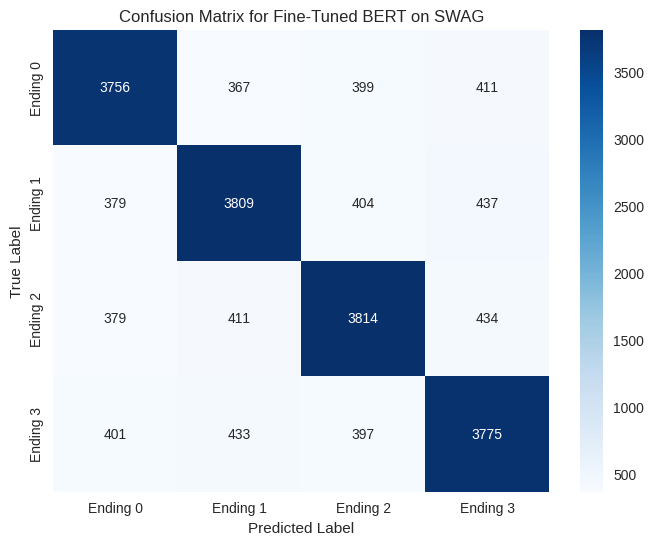

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Ending {i}' for i in range(4)],
            yticklabels=[f'Ending {i}' for i in range(4)])
plt.title('Confusion Matrix for Fine-Tuned BERT on SWAG')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## <span style="color: rgb(24, 66, 94);">**4.​ Report Your Results**</sapn>

In [ ]:
print(f"Validation Accuracy: {final_accuracy*100:.2f}%")

Validation Accuracy: 75.75%


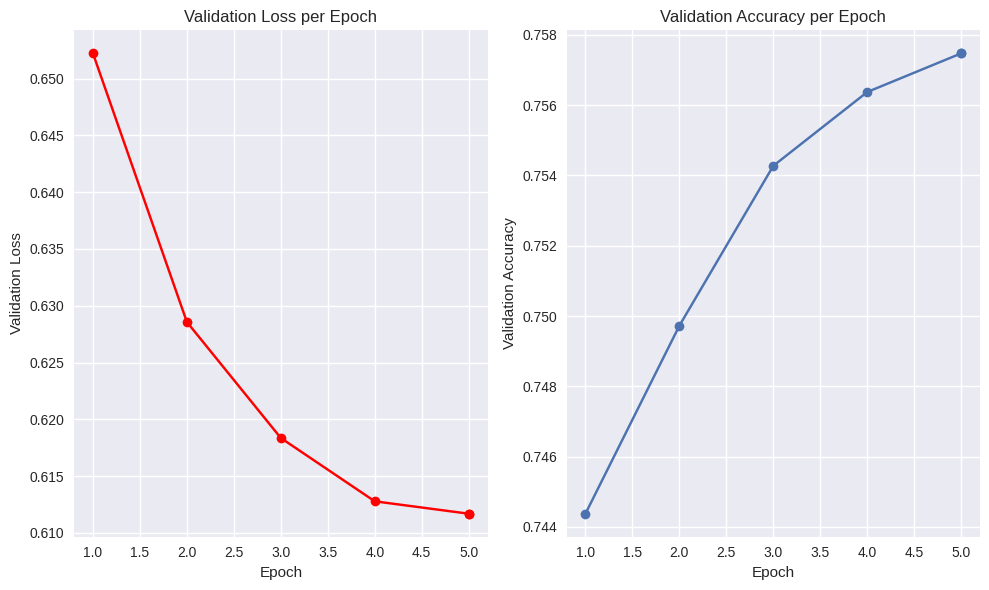

In [ ]:
epochs = []
accuracies = []
losses = []

for log_entry in trainer.state.log_history:
  if "eval_accuracy" in log_entry:
    epochs.append(log_entry["epoch"])
    losses.append(log_entry["eval_loss"])
    accuracies.append(log_entry["eval_accuracy"])
epochs = []
accuracies = []
losses = []

for log_entry in trainer.state.log_history:
  if "eval_accuracy" in log_entry:
    epochs.append(log_entry["epoch"])
    losses.append(log_entry["eval_loss"])
    accuracies.append(log_entry["eval_accuracy"])

_, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].plot(epochs, losses, color='red', marker='o')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Validation Loss")
axs[0].set_title("Validation Loss per Epoch")

axs[1].plot(epochs, accuracies, marker='o')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Validation Accuracy")
axs[1].set_title("Validation Accuracy per Epoch")

plt.grid(True)
plt.tight_layout()
plt.show()
_, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].plot(epochs, losses, color='red', marker='o')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Validation Loss")
axs[0].set_title("Validation Loss per Epoch")

axs[1].plot(epochs, accuracies, marker='o')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Validation Accuracy")
axs[1].set_title("Validation Accuracy per Epoch")

plt.grid(True)
plt.tight_layout()
plt.show()

### Compare the fine-tuned model’s performance to the earlier results

| Method | Accuracy |
|:--|:--|
|baseline (zero-shot)|32.35%|
|baseline+ICL (few-shot)|36.95%|
|baseline+ICL (CoT)|36.71%|
|fine-tuning model|75.75%|

# <span style="color:rgb(85, 186, 226);">**In-Context Learning with the Fine-Tuned Model**</sapn>

In [ ]:
base_model = AutoModelForMultipleChoice.from_pretrained(BASE_MODEL_ID).to(DEVICE)
lora_model = PeftModel.from_pretrained(base_model, FINAL_ADAPTER_PATH)
tokenizer = AutoTokenizer.from_pretrained(FINAL_ADAPTER_PATH)

lora_model.to(DEVICE)
lora_model.eval()

validation_set = swag_dataset["validation"]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
prompt_text = """Based on the context, choose the most plausible continuation.

Context: A woman is outside with a bucket and a dog. The dog is running around the yard.
Answer: The dog is running around the yard, and the dog is running around the yard.

Context: A man is in a kitchen making sandwiches. He cuts a sandwich in half.
Answer: He cuts a sandwich in half, and a man is in a kitchen making sandwiches.

---
"""


def preprocess_with_icl(batch: dict, tokenizer):
    batch_size = len(batch["sent1"])
    all_candidates = []
    for i in range(batch_size):
        context_with_icl = prompt_text + batch["sent1"][i] + " " + tokenizer.sep_token + batch["sent2"][i]

        for k in range(4):
            candidate = context_with_icl + " " + tokenizer.sep_token + " " + batch[f"ending{k}"][i]
            all_candidates.append(candidate)

    tokenized = tokenizer(all_candidates, return_tensors="pt", truncation=True, padding=True, max_length=512)
    tokenized = {k: v.view(batch_size, 4, -1) for k, v in tokenized.items()}
    tokenized["labels"] = torch.tensor(batch["label"])
    return tokenized

In [ ]:
all_preds = []
all_labels = []

for i in tqdm(range(0, len(validation_set), 16)):
    batch_dict = validation_set[i: i+32]
    inputs = preprocess_with_icl(batch_dict, tokenizer)

    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    labels = inputs.pop("labels")

    with torch.no_grad():
        outputs = base_model(**inputs)

    preds = torch.argmax(outputs.logits, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

icl_finetuned_accuracy = accuracy_score(all_labels, all_preds)

print(f"\n\nAccuracy of Fine_Tuned Model + ICL Prompt: {icl_finetuned_accuracy*100:.2f}%")

100%|██████████| 1251/1251 [23:27<00:00,  1.13s/it]




Accuracy of Fine_Tuned Model + ICL Prompt: 58.94%


# <span style="color:rgb(85, 186, 226);">**Analyse the results**</sapn>

After testing three approaches, fine-tuning, ICL, and ICL on fine-tuned model, the best performance came from fine-tuning alone.


### Why Fine-tuning Alone Performed Best?
- **Task-specific adaptation:** Fine tuning on SWAG dataset optimized `bert-base-uncased`'s weights fir the exact input format and decision boundaries of the task.

- **BERT's architecture:** As an encoder-only model, BERT processes the full sequence at once and does not autoregressively learn from examples in the prompt like generative models do. 

### Why ICL Hurt the Fine-tuned Model?
1. **Input distribution shift** – The fine-tuned model expects one question–options set. Adding multiple example Q–A pairs changes token patterns and positions in ways it never saw during training.
2. **Sequence length limit (512 tokens)** – Additional examples may push key parts of the actual question toward the end or cause truncation, degrading performance.
3. **Noise introduction** – For BERT, extra text that doesn’t directly align with its learned input schema can confuse attention and reduce accuracy.
4. **No real “few-shot learning” benefit** – BERT cannot dynamically update its reasoning from in-context examples; instead, it treats them as more text to encode.

### For Examples:
- For **BERT** on structured multiple-choice tasks like SWAG, **fine-tuning is the dominant performance driver**.  
- ICL is more useful for **generative models** or in low-resource scenarios where fine-tuning isn’t feasible.  
- Combining fine-tuning and ICL is only beneficial if the ICL examples exactly match the fine-tuning input format and do not risk truncation.


### Final Accuracy Table:
| Method | Accuracy |
|:--|:--|
|baseline (zero-shot)|32.35%|
|baseline+ICL (few-shot)|36.95%|
|baseline+ICL (CoT)|36.71%|
|fine-tuning model|75.75%|
|fine-tuning+ICL|58.94%|

# <span style="color:rgb(238, 65, 65);">**Questions**</sapn>

## 1. Choosing Between Fine-tuning, ICL, and Combining Both

**When fine-tuning is best:**
- **High performance required** – Tasks like SWAG, sentiment analysis, or domain-specific classification where accuracy is critical.
- **Stable, well-defined task** – When the problem definition and label set will not change frequently.
- **Sufficient labeled data available** – Large, high-quality training datasets exist for the target domain.
- **Long-term deployment** – When the model will be reused often, making the upfront training cost worthwhile.

**When ICL is preferred:**
- **Few-shot or zero-shot scenarios** – Little to no labeled data is available.
- **Rapid task switching** – The model must handle many different tasks without retraining.
- **Low resource constraints** – No GPU or time budget for fine-tuning.

**When to combine both:**
- **Dynamic domains** – Fine-tune for general competence, then use ICL to inject the most recent updates (e.g., new regulations, recent events).
- **Personalization** – Fine-tune on broad patterns, then adapt to user-specific needs via ICL examples.
- **Handling rare cases** – Fine-tune for common patterns, but provide ICL examples for edge cases not well represented in the training set.

---

## 2. Designing ICL Prompts for a Different Task

If the task were **predicting medical diagnoses** or **forecasting financial trends**, the ICL prompt should contain **clear, representative, and context-rich examples**.

**Example design for medical diagnosis:**
- **Case description** – Symptoms, patient history, lab results.
- **Correct label** – The diagnosis (or “most likely diagnosis”).
- **Reasoning steps** (optional) – Short explanation to guide model reasoning.

**Example design for financial forecasting:**
- **Historical data** – Time-series data points (prices, volume, macroeconomic indicators).
- **Contextual events** – News headlines, policy changes.
- **Prediction** – Expected market movement or value.

**Key factors when selecting examples:**
1. **Relevance** – Match the task format, style, and domain exactly.
2. **Coverage** – Include examples that span common and rare cases.
3. **Clarity** – Avoid ambiguity; make the input–output mapping obvious.
4. **Length constraints** – Keep total token length under the model’s limit while preserving essential details.
5. **Format consistency** – Use the same structure for all examples to help the model pick up the pattern.
